# **1. Librerías**
 Librerias para manejo de datos y modelado

In [ ]:
!pip install -q mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 752.6/752.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 6.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import f1_score, recall_score, accuracy_score, classification_report, roc_auc_score, average_precision_score, precision_recall_fscore_support,confusion_matrix
from IPython.display import display

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

import time

from google.colab import files
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE


from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, cross_validate

from sklearn.linear_model import LogisticRegression

import xgboost as xgb

from sklearn.dummy import DummyClassifier

from joblib import dump, load
import os, sys, platform, json, importlib, datetime
from pathlib import Path


# **2. Carga de datos**

In [ ]:

uploaded = files.upload()

# Cargar el archivo
df = pd.read_csv("train_FD001.txt", sep=r"\s+", header=None, engine="python")
df = df.dropna(axis=1, how='all')
n_cols = df.shape[1]

#Preprocesamiento inicial de los datos
# En CMAPSS estándar: 31 columnas = 2 (unidad, ciclo) + 3 (ajustes operativos) + 26 sensores
if n_cols == 31:
    nombres_columnas = (
        ['unidad', 'ciclo',
         'ajuste_op_1', 'ajuste_op_2', 'ajuste_op_3'] +
        [f'sensor_{i}' for i in range(1, 27)]  # sensores 1..26
    )
else:
    if n_cols > 5:
        n_sensores = n_cols - 5
        nombres_columnas = (
            ['unidad', 'ciclo',
             'ajuste_op_1', 'ajuste_op_2', 'ajuste_op_3'] +
            [f'sensor_{i}' for i in range(1, n_sensores + 1)]
        )
    else:
        nombres_columnas = [f'columna_{i}' for i in range(n_cols)]

df.columns = nombres_columnas

#Confirmar tamaño y primeras filas
print("Número de columnas detectadas:", n_cols)
print("Dimensiones del dataset:", df.shape)
df.head()

Saving train_FD001.txt to train_FD001.txt
Número de columnas detectadas: 26
Dimensiones del dataset: (20631, 26)


,unidad,ciclo,ajuste_op_1,ajuste_op_2,ajuste_op_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


# **3. Ingeniería de Datos**

Definición de la variable objetivo [Y]: La idea es predecir si el motor necesita mantenimiento antes de fallar. Para eso, se construye una etiqueta binaria basada en la Remaining Useful Life (RUL):

In [ ]:
#Calcular el ciclo máximo (ciclo de falla) de cada motor
ciclo_maximo = df.groupby('unidad')['ciclo'].max().reset_index()
ciclo_maximo.columns = ['unidad', 'ciclo_maximo']

#Unirlo al dataset
df = df.merge(ciclo_maximo, on='unidad', how='left')

#Calcular la vida útil restante (RUL)
df['RUL'] = df['ciclo_maximo'] - df['ciclo']

#Crear la etiqueta binaria|variable objetivo (1 = requiere mantenimiento, 0 = no)
umbral = 30  # ciclos de vida restante
df['requiere_mantenimiento'] = (df['RUL'] <= umbral).astype(int)
df[['unidad','ciclo','ciclo_maximo','RUL','requiere_mantenimiento']].head(20)

,unidad,ciclo,ciclo_maximo,RUL,requiere_mantenimiento
0,1,1,192,191,0
1,1,2,192,190,0
2,1,3,192,189,0
3,1,4,192,188,0
4,1,5,192,187,0
5,1,6,192,186,0
6,1,7,192,185,0
7,1,8,192,184,0
8,1,9,192,183,0
9,1,10,192,182,0


# **4. Exploración de Datos**

Total de registros y columnas:  (20631, 29)


,Indicador,Valor
0,Total de registros,20631.000000
1,Total de unidades,100.000000
2,Ciclos promedio,206.310000
3,Ciclos mínimos,128.000000
4,Unidad con menos ciclos,39.000000
5,Ciclos máximos,362.000000
6,Unidad con más ciclos,69.000000
7,Desviación estándar ciclos,46.340000


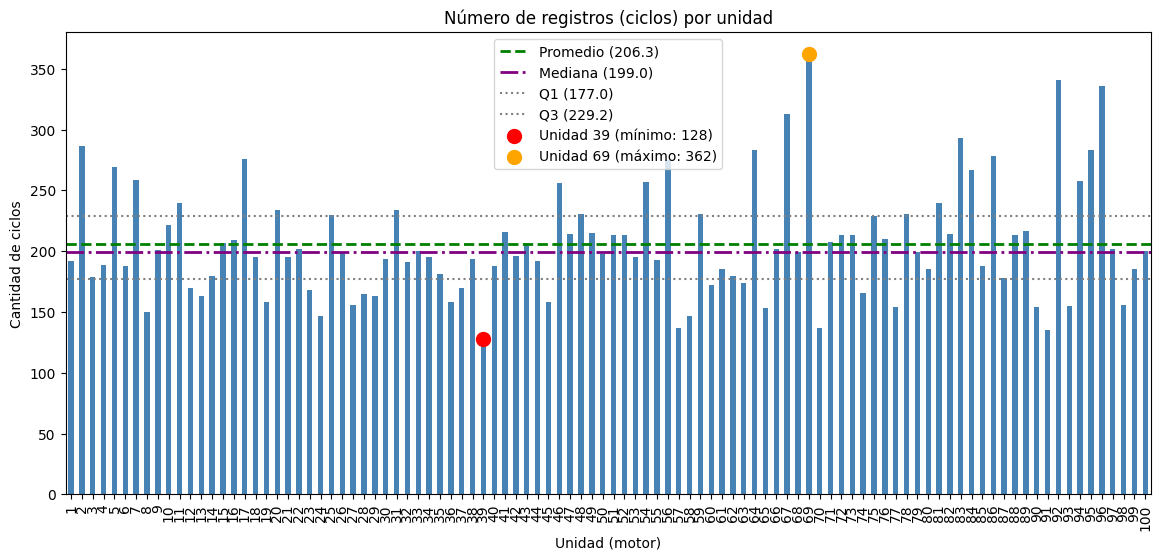

In [ ]:
# Total de registros y unidades
total_registros = len(df)
total_unidades = df['unidad'].nunique()

# Número de registros por unidad
registros_por_unidad = df.groupby('unidad').size()

# Estadísticas descriptivas
estadisticas = registros_por_unidad.describe()

# Unidades con vida más corta y más larga
unidad_min = registros_por_unidad.idxmin()
unidad_max = registros_por_unidad.idxmax()
ciclos_min = registros_por_unidad.min()
ciclos_max = registros_por_unidad.max()

# Crear tabla resumen
tabla_resumen = pd.DataFrame({
    "Indicador": [
        "Total de registros",
        "Total de unidades",
        "Ciclos promedio",
        "Ciclos mínimos",
        "Unidad con menos ciclos",
        "Ciclos máximos",
        "Unidad con más ciclos",
        "Desviación estándar ciclos"
    ],
    "Valor": [
        total_registros,
        total_unidades,
        round(estadisticas['mean'], 2),
        ciclos_min,
        unidad_min,
        ciclos_max,
        unidad_max,
        round(estadisticas['std'], 2)
    ]
})
print("Total de registros y columnas: ", df.shape)
display(tabla_resumen.style.set_table_styles(
    [{'selector': 'th', 'props': [('border', '1px solid black')]},
     {'selector': 'td', 'props': [('border', '1px solid black')]}]
).set_properties(**{'text-align': 'center'}))


plt.figure(figsize=(14,6))
registros_por_unidad.plot(kind='bar', color='steelblue')
plt.title("Número de registros (ciclos) por unidad")
plt.xlabel("Unidad (motor)")
plt.ylabel("Cantidad de ciclos")

# Indicadores
plt.axhline(y=estadisticas['mean'], color='green', linestyle='--', linewidth=2, label=f"Promedio ({estadisticas['mean']:.1f})")
plt.axhline(y=estadisticas['50%'], color='purple', linestyle='-.', linewidth=2, label=f"Mediana ({estadisticas['50%']:.1f})")
plt.axhline(y=estadisticas['25%'], color='grey', linestyle=':', linewidth=1.5, label=f"Q1 ({estadisticas['25%']:.1f})")
plt.axhline(y=estadisticas['75%'], color='grey', linestyle=':', linewidth=1.5, label=f"Q3 ({estadisticas['75%']:.1f})")
plt.scatter(unidad_min-1, ciclos_min, color='red', s=100, zorder=5, label=f"Unidad {unidad_min} (mínimo: {ciclos_min})")
plt.scatter(unidad_max-1, ciclos_max, color='orange', s=100, zorder=5, label=f"Unidad {unidad_max} (máximo: {ciclos_max})")
plt.legend()
plt.show()

La gráfica muestra la duración en ciclos de cada unidad del dataset FD001. Se
destacan los indicadores principales: el promedio (línea verde discontinua), la mediana (línea púrpura), los percentiles 25 y 75 (líneas grises punteadas) y los valores extremos correspondientes a la unidad con menor duración (punto rojo) y la de mayor duración (punto naranja). La inclusión de estos indicadores permite observar tanto la tendencia central como la variabilidad en la vida útil de los motores, evidenciando que existen diferencias significativas entre las unidades en cuanto a su tiempo de operación hasta la falla.

### **Análisis:**

La distribución del número de ciclos por unidad evidencia que cada motor presenta una duración de vida distinta antes de alcanzar la falla, con valores mínimos y máximos que varían de forma considerable. Mientras algunas unidades alcanzan la falla en pocos ciclos, otras logran operar durante un número mucho mayor de vuelos simulados. Esta variabilidad refleja que la degradación de los motores no es uniforme, lo que justifica la necesidad de aplicar técnicas de modelado predictivo que permitan anticipar el momento óptimo de intervención de manera individualizada para cada motor, en lugar de asumir un tiempo de vida estándar.

In [ ]:
def _prep_numeric_df(df_num: pd.DataFrame) -> pd.DataFrame:
    """
    Limpia un DataFrame numérico para correlaciones:
    1) Convierte a numérico (si ya lo es, no cambia)
    2) Reemplaza ±Inf por NaN
    3) Elimina columnas totalmente NaN
    4) Elimina columnas con <=1 valor distinto (constantes o casi constantes)
    5) Elimina columnas con desviación estándar 0 (sobre datos disponibles)
    """
    X = df_num.select_dtypes(include=[np.number]).copy()
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.dropna(axis=1, how='all')
    nunq = X.nunique(dropna=True)
    X = X.loc[:, nunq > 1]
    if X.shape[1] == 0:
        return X
    std = X.std(numeric_only=True)
    X = X.loc[:, std > 0]
    return X

def safe_corr_matrix(df_num: pd.DataFrame, min_periods: int = 2) -> pd.DataFrame:
    """
    Matriz de correlación Pearson libre de warnings:
    - Filtra columnas problemáticas con _prep_numeric_df
    - min_periods=2 evita divisiones inválidas
    """
    X = _prep_numeric_df(df_num)
    if X.shape[1] <= 1:
        return pd.DataFrame()
    corr = X.corr(min_periods=min_periods)
    return corr

def safe_corrwith_target(df_num: pd.DataFrame, target: pd.Series) -> pd.DataFrame:
    """
    Correlación (Pearson) de cada columna numérica con un objetivo (numérico o binario),
    sin warnings. Exige al menos 2 pares válidos y std>0 en ambas series.
    """
    X = _prep_numeric_df(df_num)
    y = pd.to_numeric(target, errors='coerce').replace([np.inf, -np.inf], np.nan)

    # Filas válidas del target
    mask = y.notna()
    X, y = X.loc[mask], y.loc[mask]

    if X.shape[1] == 0 or y.shape[0] < 2:
        return pd.DataFrame(columns=['correlacion'])

    cors = {}
    for col in X.columns:
        s = X[col]
        m = s.notna() & y.notna()
        if m.sum() >= 2 and s[m].std() > 0 and y[m].std() > 0:
            cors[col] = s[m].corr(y[m])
        else:
            cors[col] = np.nan

    out = pd.Series(cors, name='correlacion').sort_values(ascending=False).to_frame()
    out.index.name = 'columna'
    return out

def perfilado_variables(df: pd.DataFrame,
                        objetivo_continuo: str = 'RUL',
                        objetivo_binario: str = 'requiere_mantenimiento'):
    df_copy = df.copy()

    tipos = df_copy.dtypes.rename('tipo')
    n_filas = len(df_copy)
    nulos = df_copy.isna().sum().rename('n_nulos')
    pct_nulos = (nulos / n_filas * 100).round(2).rename('%_nulos')

    ceros = (df_copy == 0).sum(numeric_only=True).reindex(df_copy.columns, fill_value=0).rename('n_ceros')
    pct_ceros = ((ceros / n_filas) * 100).round(2).rename('%_ceros')
    unicos = df_copy.nunique(dropna=False).rename('n_unicos')

    #Constante / casi-constante (≥95% el valor más frecuente)
    def prop_top(s: pd.Series):
        vc = s.value_counts(dropna=False)
        return (vc.iloc[0] / n_filas) if len(vc) else np.nan

    prop_mas_frecuente = df_copy.apply(prop_top).rename('prop_mas_frecuente')
    es_constante = (unicos == 1).rename('constante')
    casi_constante = (prop_mas_frecuente >= 0.95).rename('casi_constante_>=95%')

    #Partición numéricas / categóricas
    numericas = df_copy.select_dtypes(include=[np.number]).columns.tolist()
    categoricas = [c for c in df_copy.columns if c not in numericas]

    #Estadísticas numéricas + outliers IQR
    if numericas:
        desc_num = df_copy[numericas].describe().T
        Q1 = df_copy[numericas].quantile(0.25)
        Q3 = df_copy[numericas].quantile(0.75)
        IQR = Q3 - Q1
        low = Q1 - 1.5 * IQR
        high = Q3 + 1.5 * IQR
        outliers_cnt = ((df_copy[numericas] < low) | (df_copy[numericas] > high)).sum()
        outliers_pct = (outliers_cnt / n_filas * 100).round(2)
        desc_num['outliers_IQR'] = outliers_cnt
        desc_num['%_outliers_IQR'] = outliers_pct
        desc_num = desc_num.reset_index().rename(columns={'index': 'columna'})
    else:
        desc_num = pd.DataFrame(columns=['columna'])

    # Resumen de categóricas (Top-3)
    resumen_cat_rows = []
    for c in categoricas:
        s = df_copy[c]
        vc = s.value_counts(dropna=False).head(3)
        fila = {
            'columna': c,
            'tipo': s.dtype,
            'n_unicos': s.nunique(dropna=False),
            'top1_valor': (vc.index[0] if len(vc) > 0 else np.nan),
            'top1_freq':  (int(vc.iloc[0]) if len(vc) > 0 else np.nan),
            'top2_valor': (vc.index[1] if len(vc) > 1 else np.nan),
            'top2_freq':  (int(vc.iloc[1]) if len(vc) > 1 else np.nan),
            'top3_valor': (vc.index[2] if len(vc) > 2 else np.nan),
            'top3_freq':  (int(vc.iloc[2]) if len(vc) > 2 else np.nan),
        }
        resumen_cat_rows.append(fila)
    desc_cat = pd.DataFrame(resumen_cat_rows)

    #Correlaciones
    corr_rul_tab = pd.DataFrame()
    if (objetivo_continuo in df_copy.columns and
        pd.api.types.is_numeric_dtype(df_copy[objetivo_continuo]) and len(numericas) > 0):
        corr_rul_tab = safe_corrwith_target(df_copy[numericas], df_copy[objetivo_continuo])

    corr_bin_tab = pd.DataFrame()
    if (objetivo_binario in df_copy.columns and
        pd.api.types.is_numeric_dtype(df_copy[objetivo_binario]) and len(numericas) > 0):
        corr_bin_tab = safe_corrwith_target(df_copy[numericas], df_copy[objetivo_binario])

    #Tabla maestra por columna
    base = pd.concat([tipos, nulos, pct_nulos, ceros, pct_ceros, unicos,
                      es_constante, casi_constante, prop_mas_frecuente], axis=1)
    base = base.reset_index().rename(columns={'index': 'columna'})
    base = base.sort_values(by=['tipo', 'columna']).reset_index(drop=True)

    resultados = {
        'tabla_maestra_columnas': base,
        'resumen_numericas': desc_num,
        'resumen_categoricas': desc_cat,
        'correlacion_con_RUL': corr_rul_tab,
        'correlacion_con_objetivo_binario': corr_bin_tab,
        'lista_numericas': numericas,
        'lista_categoricas': categoricas
    }
    return resultados

def heatmap_sensores_vs_RUL(df, col_obj='RUL'):
    num_df = df.select_dtypes(include=[np.number]).copy()
    if col_obj not in num_df.columns:
        print(f"[Aviso] No existe la columna objetivo continua '{col_obj}'.")
        return
    # Tomar sensores + RUL y limpiar
    cols_sens = [c for c in num_df.columns if c.startswith('sensor_')]
    X = num_df[cols_sens + [col_obj]]
    X = _prep_numeric_df(X)
    if col_obj not in X.columns:
        print(f"[Aviso] '{col_obj}' quedó fuera tras limpieza (NaN/std=0).")
        return
    corr = safe_corr_matrix(X)
    if corr.empty:
        print("[Aviso] No hay suficientes columnas válidas para correlación.")
        return
    # Orden por |corr| con RUL
    orden = corr[col_obj].abs().sort_values(ascending=False).index
    corr_plot = corr.loc[orden, [col_obj]]

    plt.figure(figsize=(6, max(8, 0.3*len(orden))))
    sns.heatmap(corr_plot, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.title("Mapa de calor: Correlación Sensores vs RUL")
    plt.ylabel("Variables")
    plt.xlabel("")
    plt.show()

def heatmap_sensores_vs_binario(df, col_obj='requiere_mantenimiento'):
    num_df = df.select_dtypes(include=[np.number]).copy()
    if col_obj not in num_df.columns:
        print(f"[Aviso] No existe la columna objetivo binaria '{col_obj}'.")
        return
    cols_sens = [c for c in num_df.columns if c.startswith('sensor_')]
    X = num_df[cols_sens + [col_obj]]
    X = _prep_numeric_df(X)
    if col_obj not in X.columns:
        print(f"[Aviso] '{col_obj}' quedó fuera tras limpieza (NaN/std=0).")
        return
    corr = safe_corr_matrix(X)
    if corr.empty:
        print("[Aviso] No hay suficientes columnas válidas para correlación.")
        return
    orden = corr[col_obj].abs().sort_values(ascending=False).index
    corr_plot = corr.loc[orden, [col_obj]]

    plt.figure(figsize=(6, max(8, 0.3*len(orden))))
    sns.heatmap(corr_plot, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.title("Mapa de calor: Correlación Sensores vs Requiere Mantenimiento")
    plt.ylabel("Variables")
    plt.xlabel("")
    plt.show()

def heatmap_multicolinealidad_sensores(df):
    num_df = df.select_dtypes(include=[np.number]).copy()
    cols_sens = [c for c in num_df.columns if c.startswith('sensor_')]
    if not cols_sens:
        print("[Aviso] No hay columnas 'sensor_' en el dataset.")
        return
    X = _prep_numeric_df(num_df[cols_sens])
    corr = safe_corr_matrix(X)
    if corr.empty:
        print("[Aviso] No hay suficientes columnas válidas para correlación.")
        return
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0)
    plt.title("Mapa de calor: Correlación entre Sensores (multicolinealidad)")
    plt.show()

def mostrar_con_bordes(df_):
    if df_ is None or df_.empty:
        print("(Tabla vacía)")
        return
    display(
        df_.style.set_table_styles(
            [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
        ).set_properties(**{'text-align': 'center'})
    )

#Perfilado
res = perfilado_variables(df, objetivo_continuo='RUL', objetivo_binario='requiere_mantenimiento')

print("TABLA MAESTRA (estructura/calidad por columna)")
mostrar_con_bordes(res['tabla_maestra_columnas'])

print("\nRESUMEN NUMÉRICAS (describe + outliers IQR)")
mostrar_con_bordes(res['resumen_numericas'])

print("\nRESUMEN CATEGÓRICAS (Top-3 frecuencias)")
mostrar_con_bordes(res['resumen_categoricas'])




TABLA MAESTRA (estructura/calidad por columna)


,columna,tipo,n_nulos,%_nulos,n_ceros,%_ceros,n_unicos,constante,casi_constante_>=95%,prop_mas_frecuente
0,RUL,int64,0,0.000000,100,0.480000,362,False,False,0.004847
1,ciclo,int64,0,0.000000,0,0.000000,362,False,False,0.004847
2,ciclo_maximo,int64,0,0.000000,0,0.000000,66,False,False,0.051621
3,requiere_mantenimiento,int64,0,0.000000,17531,84.970000,2,False,False,0.849741
4,sensor_17,int64,0,0.000000,0,0.000000,13,False,False,0.263923
5,sensor_18,int64,0,0.000000,0,0.000000,1,True,True,1.000000
6,unidad,int64,0,0.000000,0,0.000000,100,False,False,0.017546
7,ajuste_op_1,float64,0,0.000000,413,2.000000,158,False,False,0.020018
8,ajuste_op_2,float64,0,0.000000,2070,10.030000,13,False,False,0.101982
9,ajuste_op_3,float64,0,0.000000,0,0.000000,1,True,True,1.000000



RESUMEN NUMÉRICAS (describe + outliers IQR)


,columna,count,mean,std,min,25%,50%,75%,max,outliers_IQR,%_outliers_IQR
0,unidad,20631.000000,51.506568,29.227633,1.000000,26.000000,52.000000,77.000000,100.000000,0,0.000000
1,ciclo,20631.000000,108.807862,68.880990,1.000000,52.000000,104.000000,156.000000,362.000000,104,0.500000
2,ajuste_op_1,20631.000000,-0.000009,0.002187,-0.008700,-0.001500,0.000000,0.001500,0.008700,105,0.510000
3,ajuste_op_2,20631.000000,0.000002,0.000293,-0.000600,-0.000200,0.000000,0.000300,0.000600,0,0.000000
4,ajuste_op_3,20631.000000,100.000000,0.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0,0.000000
5,sensor_1,20631.000000,518.670000,0.000000,518.670000,518.670000,518.670000,518.670000,518.670000,0,0.000000
6,sensor_2,20631.000000,642.680934,0.500053,641.210000,642.325000,642.640000,643.000000,644.530000,128,0.620000
7,sensor_3,20631.000000,1590.523119,6.131150,1571.040000,1586.260000,1590.100000,1594.380000,1616.910000,165,0.800000
8,sensor_4,20631.000000,1408.933782,9.000605,1382.250000,1402.360000,1408.040000,1414.555000,1441.490000,120,0.580000
9,sensor_5,20631.000000,14.620000,0.000000,14.620000,14.620000,14.620000,14.620000,14.620000,0,0.000000



RESUMEN CATEGÓRICAS (Top-3 frecuencias)
(Tabla vacía)


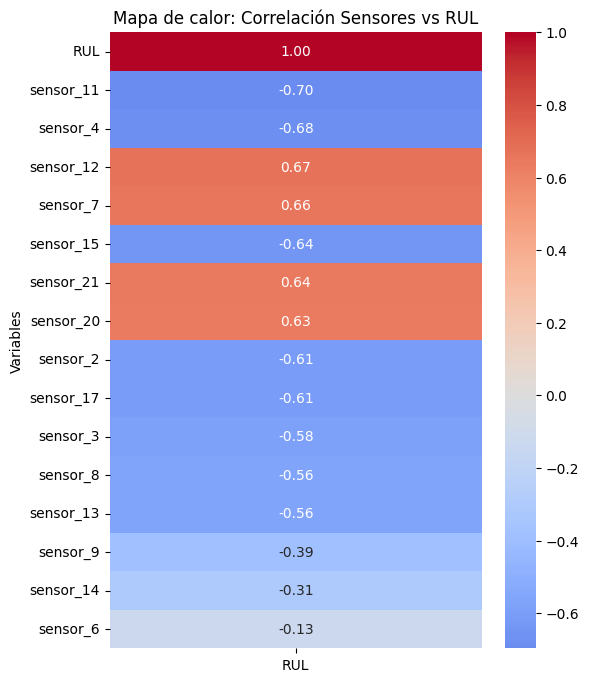

In [ ]:
heatmap_sensores_vs_RUL(df, col_obj='RUL')


## **Análisis:**
El análisis de correlación evidencia que los sensores relacionados con la dinámica térmica y de presión del motor son los más informativos respecto a la vida útil restante (RUL). En particular, la temperatura de entrada al compresor de alta (sensor 11), la presión de salida de la turbina de baja (sensor 4), la presión y temperatura en el compresor de alta (sensores 12 y 7), la temperatura de salida de la cámara de combustión (sensor 15), la temperatura de los gases de escape (sensor 21) y la relación de velocidad del núcleo (sensor 20) presentan correlaciones absolutas superiores a 0.60. Estos parámetros reflejan de manera directa el deterioro progresivo del motor, por lo que constituyen variables clave en la construcción del modelo predictivo. En contraste, sensores como la presión del conducto de bypass (sensor 6) o la relación aire-combustible (sensor 14) muestran una relación débil con el RUL, indicando una contribución limitada al modelo.

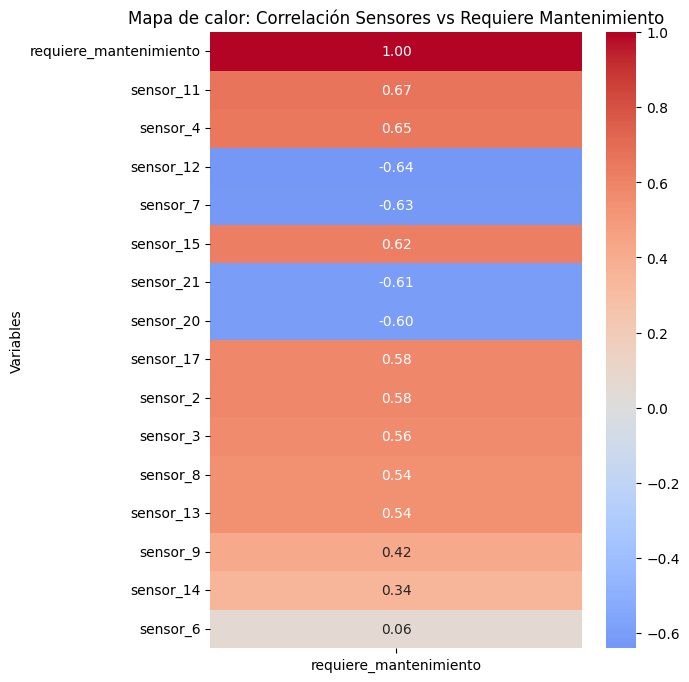

In [ ]:
heatmap_sensores_vs_binario(df, col_obj='requiere_mantenimiento')


## **Análisis:**
El análisis de correlación entre los sensores y la variable binaria de mantenimiento revela que los parámetros termodinámicos y de presión del motor constituyen los principales predictores de falla. En particular, la temperatura de entrada al compresor de alta (sensor 11), la presión de salida de la turbina de baja (sensor 4), la presión y temperatura en el compresor (sensores 12 y 7), la temperatura de la cámara de combustión (sensor 15), la temperatura de los gases de escape (sensor 21) y la relación de velocidad del núcleo (sensor 20) presentan correlaciones absolutas cercanas o superiores a 0.60. Esto confirma que dichas variables son determinantes en la clasificación de equipos que requieren mantenimiento. Por el contrario, parámetros como la presión en el conducto de bypass (sensor 6) muestran escasa relación con la condición de mantenimiento, por lo que su relevancia en el modelo predictivo es limitada

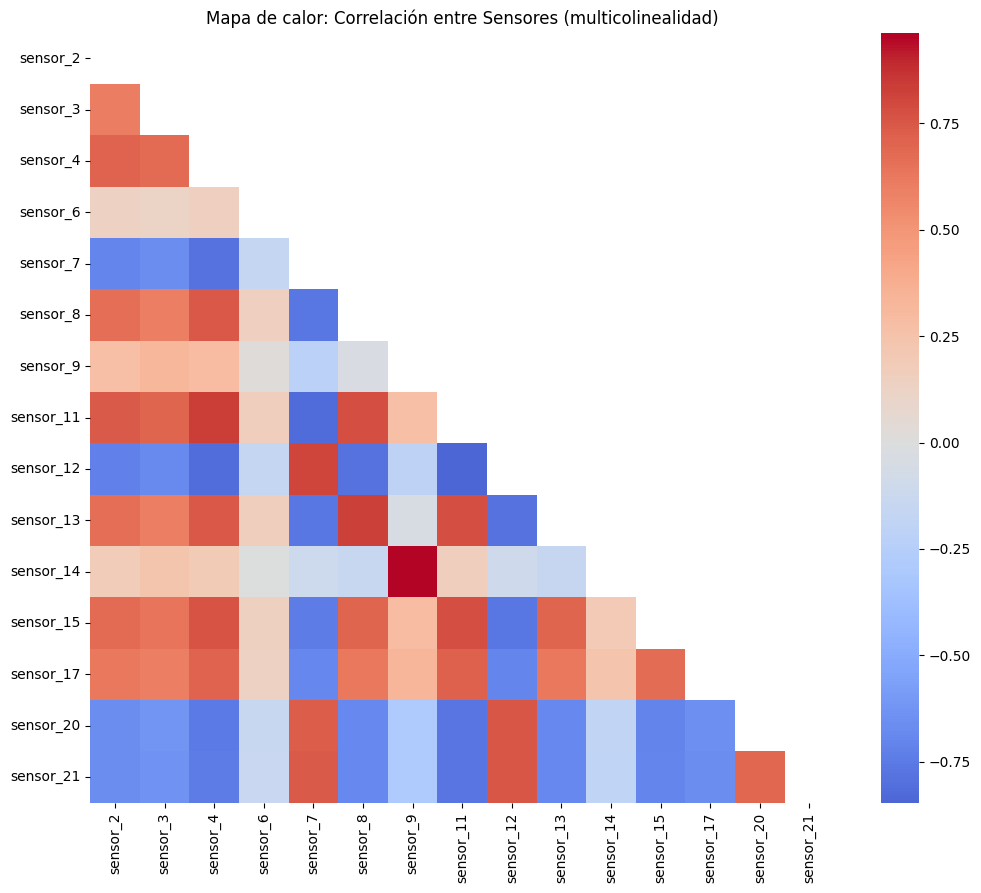

In [ ]:
heatmap_multicolinealidad_sensores(df)



## **Análisis:**
El análisis de correlación entre sensores muestra la existencia de bloques de variables altamente relacionadas, lo que evidencia multicolinealidad. Destacan las fuertes asociaciones entre el sensor 14 (relación aire-combustible) y el sensor 9 (velocidad del ventilador), así como entre los sensores de temperatura en distintas etapas del motor: sensor 7 (salida LPC), sensor 8 (salida HPC), sensor 15 (salida de combustión) y sensor 21 (gases de escape). De manera similar, los sensores de presión en el compresor y la turbina (sensores 2, 4 y 12) muestran correlaciones elevadas. Estas redundancias, aunque esperables desde el punto de vista físico, refuerzan la necesidad de aplicar técnicas de reducción de dimensionalidad como PCA, que permitan disminuir la multicolinealidad y optimizar el desempeño del modelo predictivo.

In [ ]:
rank_corr_rul = safe_corrwith_target(df.select_dtypes(include=[np.number]), df['RUL']) \
                if 'RUL' in df.columns else pd.DataFrame()
rank_corr_bin = safe_corrwith_target(df.select_dtypes(include=[np.number]), df['requiere_mantenimiento']) \
                if 'requiere_mantenimiento' in df.columns else pd.DataFrame()

print("\nRANKING (tabla): Correlación con RUL (|mayor→menor|)")
mostrar_con_bordes(rank_corr_rul.reindex(rank_corr_rul['correlacion'].abs().sort_values(ascending=False).index)
                   if not rank_corr_rul.empty else pd.DataFrame())

print("\nRANKING (tabla): Correlación con Requiere Mantenimiento (|mayor→menor|)")
mostrar_con_bordes(rank_corr_bin.reindex(rank_corr_bin['correlacion'].abs().sort_values(ascending=False).index)
                   if not rank_corr_bin.empty else pd.DataFrame())



RANKING (tabla): Correlación con RUL (|mayor→menor|)


,correlacion
columna,
RUL,1.000000
ciclo,-0.736241
sensor_11,-0.696228
sensor_4,-0.678948
sensor_12,0.671983
sensor_7,0.657223
sensor_15,-0.642667
sensor_21,0.635662
sensor_20,0.629428



RANKING (tabla): Correlación con Requiere Mantenimiento (|mayor→menor|)


,correlacion
columna,
requiere_mantenimiento,1.000000
sensor_11,0.665655
sensor_4,0.648406
sensor_12,-0.640174
sensor_7,-0.625592
sensor_15,0.618732
sensor_21,-0.606480
sensor_20,-0.599912
sensor_17,0.583067


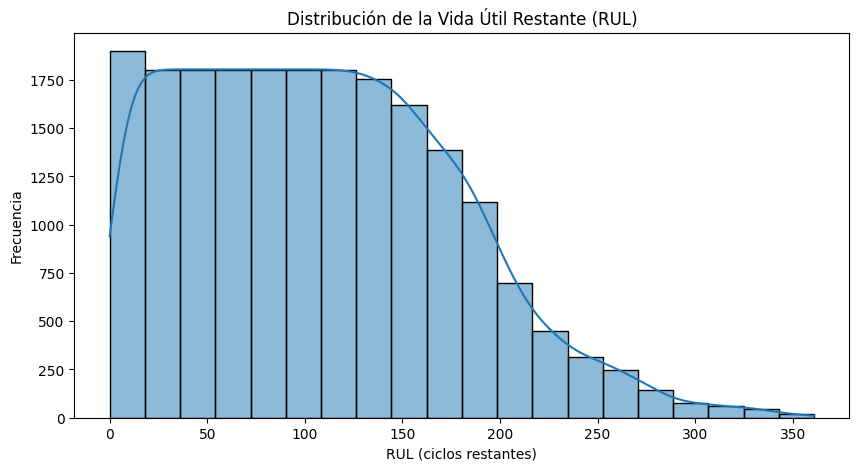

In [ ]:
#Distribución de RUL
plt.figure(figsize=(10,5))
sns.histplot(df['RUL'], bins=20, kde=True)
plt.title("Distribución de la Vida Útil Restante (RUL)")
plt.xlabel("RUL (ciclos restantes)")
plt.ylabel("Frecuencia")
plt.show()



## **Análisis:**
Esta distribución es coherente con la lógica de un sistema en degradación: cada motor genera múltiples lecturas a lo largo de su ciclo de vida, por lo que es más común encontrar registros cuando la máquina ya ha consumido parte importante de su vida útil que al inicio de la operación.

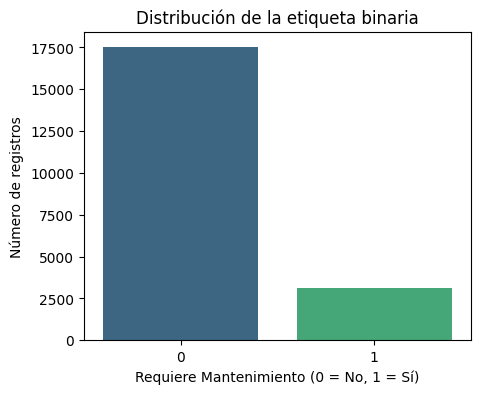

In [ ]:
#Distribución de la variable objetivo
plt.figure(figsize=(5,4))
sns.countplot(
    x='requiere_mantenimiento',
    data=df,
    hue='requiere_mantenimiento',
    palette='viridis',
    legend=False
)
plt.title("Distribución de la etiqueta binaria")
plt.xlabel("Requiere Mantenimiento (0 = No, 1 = Sí)")
plt.ylabel("Número de registros")
plt.show()



## **Análisis:**
La variable objetivo está desbalanceada esto implica que una de las clases tiene muchos más ejemplos que la otra. Esto es importante dado que será necesario aplicar técnicas de balanceo de datos en la etapa de ingeniería de variables.

Variables clave para EDA (fuente: Varianza): ['sensor_9', 'sensor_14', 'sensor_4', 'sensor_3', 'sensor_17', 'sensor_7', 'sensor_12', 'sensor_2', 'sensor_11', 'sensor_20', 'sensor_21', 'sensor_13']


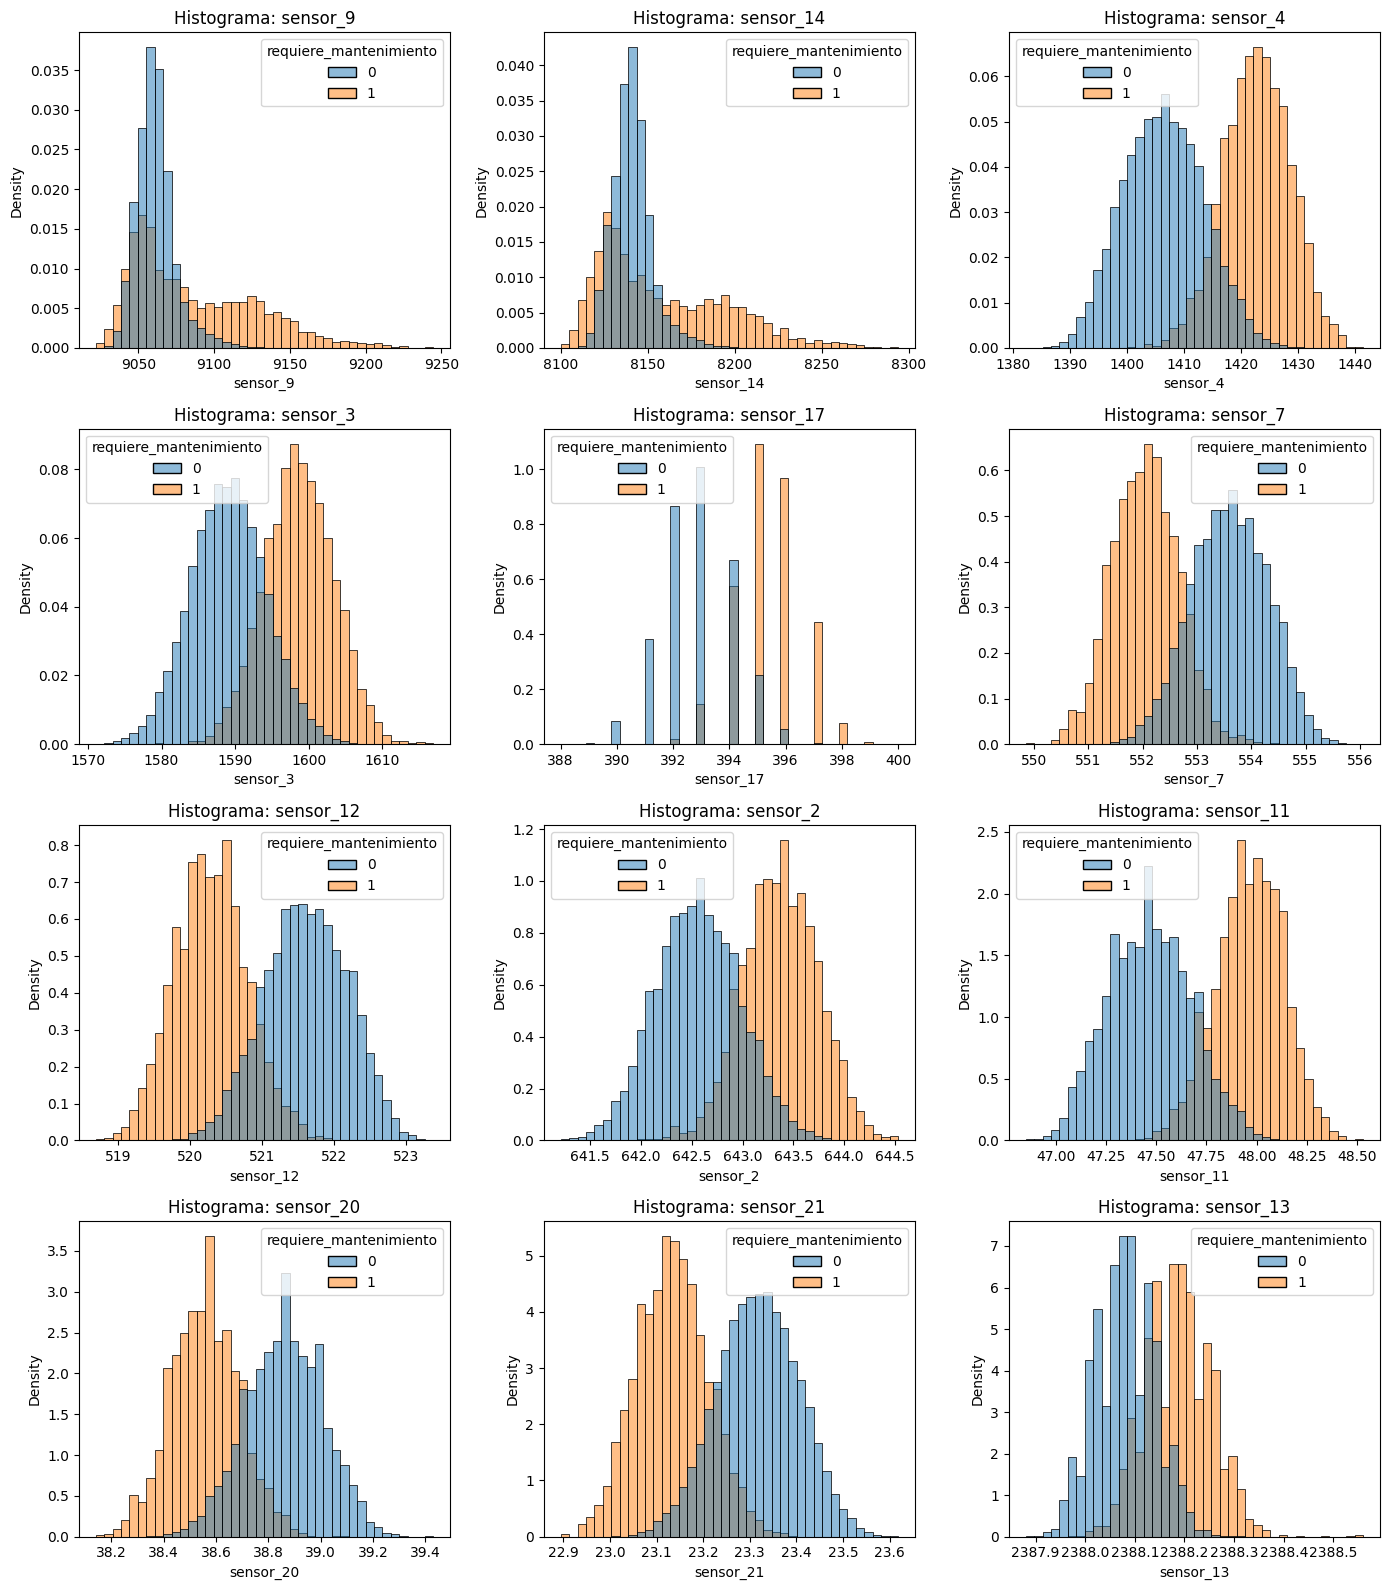

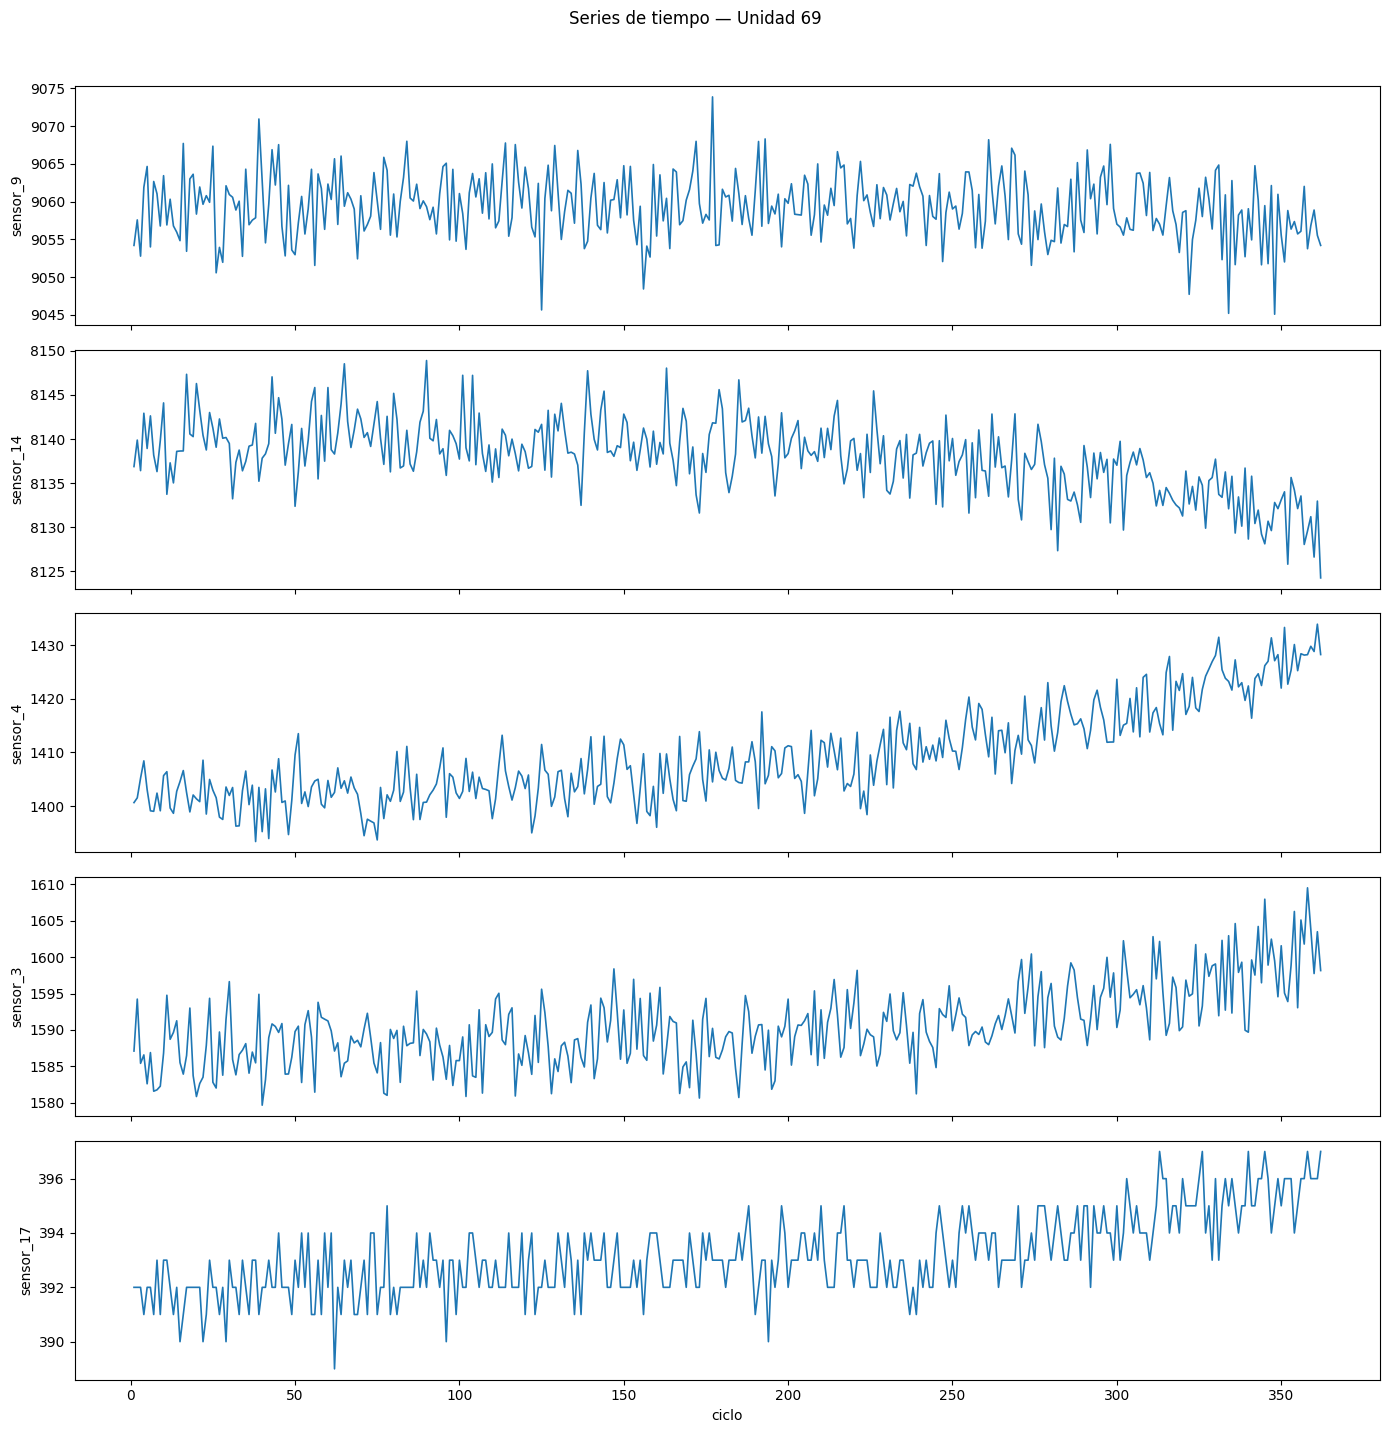

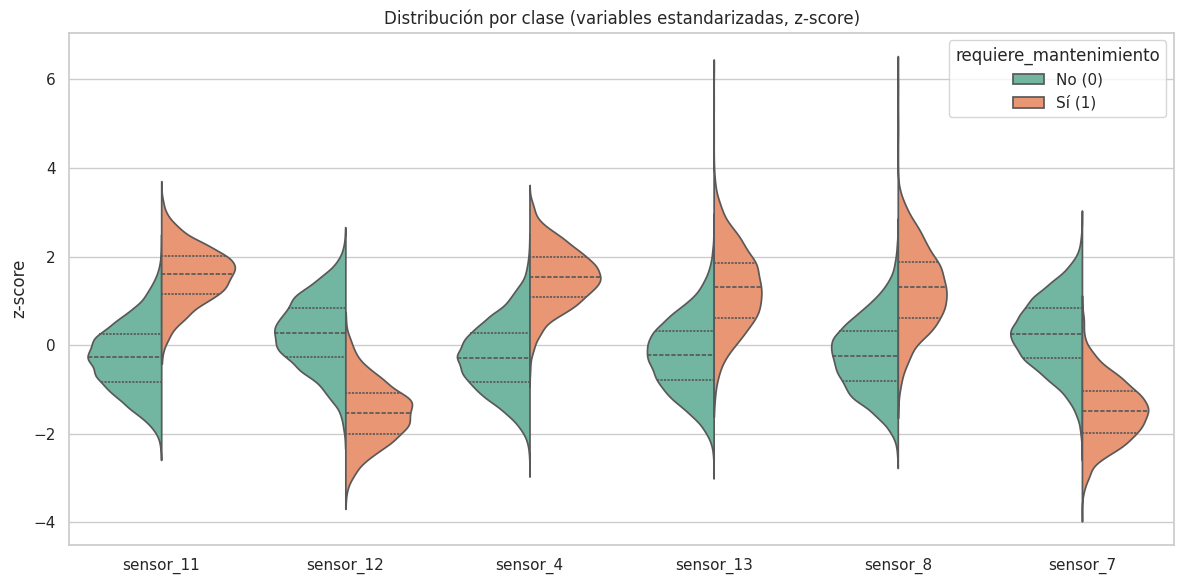

In [ ]:
def show(df, title):
    print(f"=== {title} ===")
    display(
        df.style.set_table_styles(
            [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
        ).set_properties(**{'text-align': 'center'})
    )

sensores = [c for c in df.columns if c.startswith('sensor_')]
ajustes  = [c for c in df.columns if c.startswith('ajuste_op_')]
features = sensores
target   = 'requiere_mantenimiento'
grupos   = df['unidad']

X = df[features].copy()
y = df[target].astype(int).copy()


target = "requiere_mantenimiento"
sensores = [c for c in df.columns if c.startswith("sensor_")]
cols_keep_eda = sensores
try:

    top_vars = (
        shap_mean.sort_values("shap_abs_mean", ascending=False)["variable"]
        .tolist()
    )[:12]
    fuente_top = "SHAP (importancia global)"
except Exception:
    top_vars = (
        df[cols_keep_eda].var().sort_values(ascending=False).index.tolist()
    )[:12]
    fuente_top = "Varianza"

print(f"Variables clave para EDA (fuente: {fuente_top}): {top_vars}")

os.makedirs("figuras_eda", exist_ok=True)

n = min(12, len(top_vars))
ncols = 3
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4*nrows))
axes = axes.ravel()

for i, col in enumerate(top_vars[:n]):
    ax = axes[i]
    sns.histplot(data=df, x=col, hue=target, bins=40, stat="density", common_norm=False, ax=ax)
    ax.set_title(f"Histograma: {col}")
for j in range(i+1, nrows*ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("figuras_eda/eda_histogramas.png", dpi=160)
plt.show()


cand_t = [c for c in df.columns if c.lower() in ("ciclo","cycle","time","timestamp","tiempo")]
time_col = cand_t[0] if cand_t else None

if "unidad" in df.columns:
    unidad_top = df["unidad"].value_counts().idxmax()
    df_u = df[df["unidad"] == unidad_top].copy()
    subt = f"Unidad {unidad_top}"
else:
    df_u = df.copy()
    subt = "Muestra global (sin columna unidad)"

# orden temporal
if time_col is not None:
    df_u = df_u.sort_values(time_col)
    x = df_u[time_col].values
    xtitle = time_col
else:
    df_u = df_u.reset_index(drop=True)
    x = df_u.index.values
    xtitle = "indice"

sel_series = top_vars[:5]
fig, axes = plt.subplots(len(sel_series), 1, figsize=(14, 2.8*len(sel_series)), sharex=True)
if len(sel_series) == 1:
    axes = [axes]

for ax, col in zip(axes, sel_series):
    ax.plot(x, df_u[col].values, linewidth=1.2)
    ax.set_ylabel(col)
axes[-1].set_xlabel(xtitle)
fig.suptitle(f"Series de tiempo — {subt}", y=1.02, fontsize=12)
plt.tight_layout()
plt.savefig("figuras_eda/eda_series_tiempo.png", dpi=160, bbox_inches="tight")
plt.show()


# VIOLINPLOTS POR CLASE
sns.set(style="whitegrid")

target = "requiere_mantenimiento"
vars_plot = ["sensor_11","sensor_12","sensor_4","sensor_13","sensor_8","sensor_7"]  # ajusta

tmp = df[[target] + vars_plot].copy()
for c in vars_plot:
    tmp[c] = (tmp[c] - tmp[c].mean()) / (tmp[c].std() + 1e-9)

m = tmp.melt(id_vars=target, var_name="variable", value_name="z")
m[target] = m[target].map({0:"No (0)",1:"Sí (1)"})

plt.figure(figsize=(12,6))
sns.violinplot(data=m, x="variable", y="z", hue=target,
               split=True, inner="quartile", palette="Set2", cut=0)
plt.title("Distribución por clase (variables estandarizadas, z-score)")
plt.xlabel(""); plt.ylabel("z-score")
plt.tight_layout(); plt.show()



## **5. Ingeniería de variables, entrenamiento y evaluación del modelos**

2025/10/30 13:49:59 INFO mlflow.tracking.fluent: Experiment with name 'mantenimiento_predictivo' does not exist. Creating a new experiment.


=== RESUMEN DE VARIANZA ===


,Indicador,Valor
0,Sensores iniciales,21
1,Sensores útiles tras varianza,15


=== DIVISIÓN DE DATOS POR UNIDAD ===


,Conjunto,Filas,Columnas
0,Train,16561,15
1,Test,4070,15


=== DISTRIBUCIÓN DE LA ETIQUETA (antes y después de SMOTE) ===


,Clase,Train antes (#),Train antes (%),Test antes (#),Test antes (%),Train SMOTE (#)
0,No (0),14081,85.03,3450,84.77,14081
1,Sí (1),2480,14.97,620,15.23,14081


=== RESUMEN PCA ===


,Indicador,Valor
0,Componentes PCA retenidos,9
1,Varianza explicada acumulada (%),95.61


=== VALIDACIÓN CRUZADA k=5 (media ± DE) ===


,Métrica,Media,STD
0,ROC_AUC,0.989400,0.000600
1,PR_AUC,0.950600,0.004500


=== === COMPARATIVA DE MODELOS (ordenado por F1@opt) === ===


,Modelo,ACC@0.50,PRC@0.50,REC@0.50,F1@0.50,ROC_AUC,PR_AUC,TH_optF1,F1@opt,REC@opt,Train_s,Pred_ms,Complejidad,Fuente
0,MLP,0.934398,0.708876,0.966129,0.817747,0.991686,0.962321,0.800000,0.882353,0.895161,4.254000,18.982000,Paráms≈2.753,Goodfellow et al. (2016)
1,LogisticRegression,0.934889,0.708578,0.972581,0.819850,0.991366,0.958838,0.800000,0.879811,0.903226,0.047000,0.689000,Coef=9,scikit-learn
2,XGBoost,0.938084,0.730000,0.941935,0.822535,0.988312,0.948719,0.850000,0.859766,0.830645,1.735000,56.691000,Boosting: 600 x depth 5,Chen & Guestrin (2016)
3,RandomForest,0.944226,0.757536,0.932258,0.835864,0.988780,0.946562,0.800000,0.856901,0.816129,43.174000,195.630000,"Árboles=400, depth=None",Breiman (2001)
4,Dummy (estratificado),0.505160,0.156650,0.512903,0.240000,0.508336,0.154548,0.050000,0.240000,0.512903,0.002000,0.789000,N/A,baseline



=== MODELO SELECCIONADO ===
  Seleccionado  Umbral óptimo (F1)
0          MLP                 0.8
=== MATRIZ DE CONFUSIÓN (TEST) — MLP @TH=0.80 ===


,Pred 0,Pred 1
Real 0,3367,83
Real 1,65,555



=== REPORTE DE CLASIFICACIÓN (TEST) — MLP @TH=0.80 ===
              precision    recall  f1-score   support

           0   0.981061  0.975942  0.978495      3450
           1   0.869906  0.895161  0.882353       620

    accuracy                       0.963636      4070
   macro avg   0.925483  0.935552  0.930424      4070
weighted avg   0.964128  0.963636  0.963849      4070

=== COMPARATIVA FINAL (F1 principal, tiempos, complejidad y fuente) ===


,Modelo,F1@opt,REC@opt,ROC_AUC,PR_AUC,TH_optF1,Train_s,Pred_ms,Complejidad,Fuente
0,MLP,0.882353,0.895161,0.991686,0.962321,0.800000,4.254000,18.982000,Paráms≈2.753,Goodfellow et al. (2016)
1,LogisticRegression,0.879811,0.903226,0.991366,0.958838,0.800000,0.047000,0.689000,Coef=9,scikit-learn
2,XGBoost,0.859766,0.830645,0.988312,0.948719,0.850000,1.735000,56.691000,Boosting: 600 x depth 5,Chen & Guestrin (2016)
3,RandomForest,0.856901,0.816129,0.988780,0.946562,0.800000,43.174000,195.630000,"Árboles=400, depth=None",Breiman (2001)
4,Dummy (estratificado),0.240000,0.512903,0.508336,0.154548,0.050000,0.002000,0.789000,N/A,baseline


Exportado pipeline API en: /content/artefactos_modelo
Retroproyección no disponible: el modelo seleccionado no es lineal (coef_) o no hay PCA.
=== TOP-20 VARIABLES POR SHAP ABSOLUTO (modelo auxiliar sin PCA) ===


,variable,shap_abs_mean
7,sensor_11,0.945139
8,sensor_12,0.788279
2,sensor_4,0.649477
9,sensor_13,0.632296
5,sensor_8,0.558410
4,sensor_7,0.523424
6,sensor_9,0.468707
10,sensor_14,0.427574
11,sensor_15,0.348368
0,sensor_2,0.325837


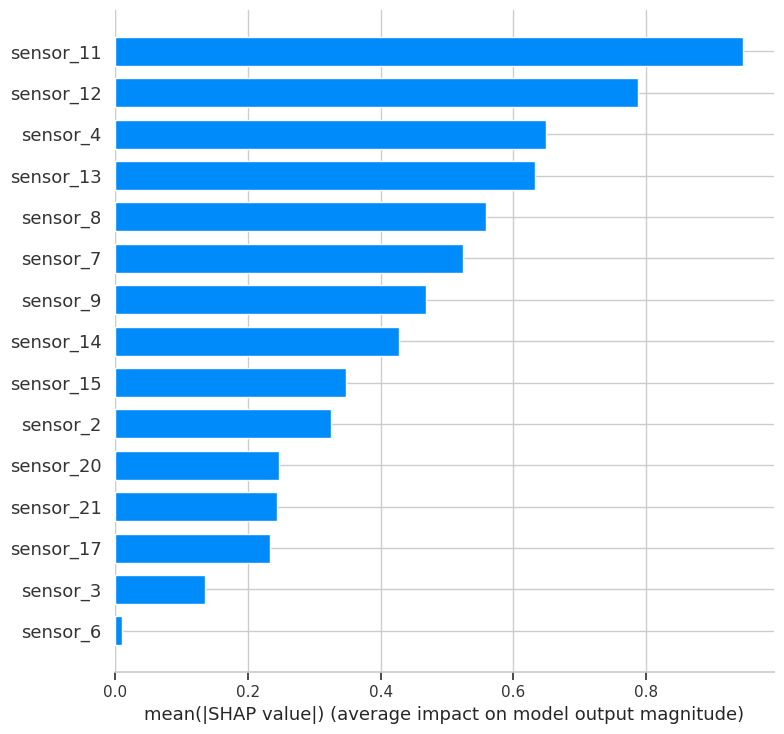

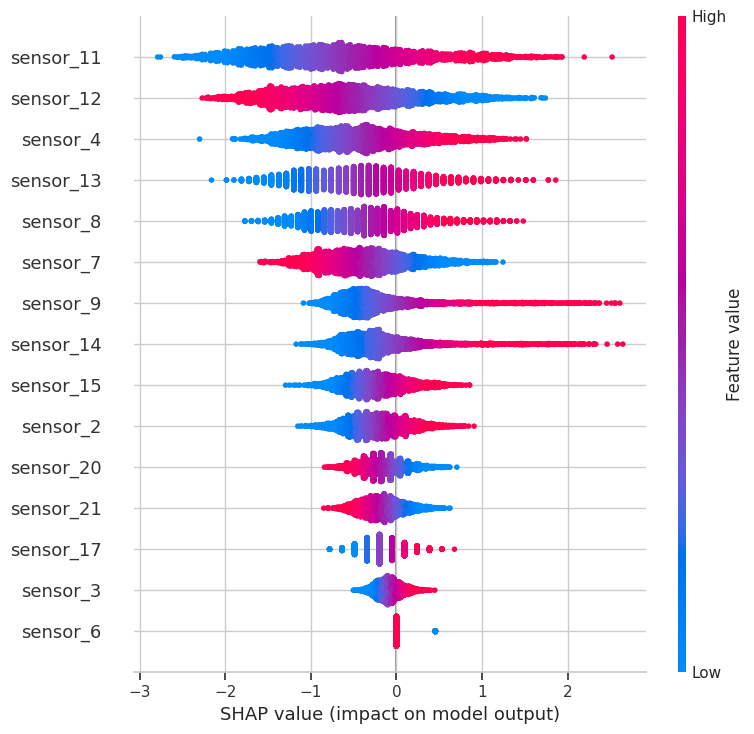

Figuras SHAP guardadas en: figuras/shap_bar.png y figuras/shap_summary.png


In [ ]:
def show(df, title):
    print(f"=== {title} ===")
    try:
        display(df.style.set_table_styles(
            [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
        ).set_properties(**{'text-align': 'center'}))
    except Exception:
        print(df)

HAS_MLFLOW = False
try:
    import mlflow, mlflow.sklearn
    HAS_MLFLOW = True
    os.environ["MLFLOW_TRACKING_URI"] = os.getenv("MLFLOW_TRACKING_URI", "mlruns")
    mlflow.set_experiment("mantenimiento_predictivo")
except Exception as e:
    print(f"MLflow no disponible ({e}).")

# Definición de variables
sensores = [c for c in df.columns if c.startswith('sensor_')]
ajustes  = [c for c in df.columns if c.startswith('ajuste_op_')]
features = sensores
target   = 'requiere_mantenimiento'
grupos   = df['unidad']

X = df[features].copy()
y = df[target].astype(int).copy()

# Eliminar la varianza
umbral_var = 1e-8
sel = VarianceThreshold(threshold=umbral_var)
X_var = sel.fit_transform(X)
cols_keep = [col for col, keep in zip(features, sel.get_support()) if keep]
X = pd.DataFrame(X_var, columns=cols_keep, index=df.index)

tabla_varianza = pd.DataFrame({
    "sensor": features,
    "varianza": df[features].var(ddof=0).values,
    "n_unicos": df[features].nunique(dropna=False).values,
    "conservada": [col in cols_keep for col in features]
})
tabla_varianza["motivo"] = np.where(
    tabla_varianza["conservada"],
    "Conservada (varianza > umbral)",
    np.where(tabla_varianza["n_unicos"] <= 1,
             "Descartada: constante (n_unicos ≤ 1)",
             f"Descartada: varianza ≤ {umbral_var:g}")
)

resumen_varianza = pd.DataFrame({
    "Indicador": ["Sensores iniciales", "Sensores útiles tras varianza"],
    "Valor":     [len(features), len(cols_keep)]
})
show(resumen_varianza, "RESUMEN DE VARIANZA")

# División del dataset en TRAIN/TEST
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=grupos))

X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
y_train, y_test = y.iloc[train_idx].copy(), y.iloc[test_idx].copy()

tabla_split = pd.DataFrame({
    "Conjunto": ["Train", "Test"],
    "Filas":    [X_train.shape[0], X_test.shape[0]],
    "Columnas": [X_train.shape[1], X_test.shape[1]],
})
show(tabla_split, "DIVISIÓN DE DATOS POR UNIDAD")

# Escalamiento MIN-MAX
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Balanceo de datos con SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

tabla_clases = pd.DataFrame({
    "Clase": ["No (0)", "Sí (1)"],
    "Train antes (#)": [(y_train==0).sum(), (y_train==1).sum()],
    "Train antes (%)": [f"{(y_train==0).mean()*100:.2f}", f"{(y_train==1).mean()*100:.2f}"],
    "Test  antes (#)": [(y_test==0).sum(), (y_test==1).sum()],
    "Test  antes (%)": [f"{(y_test==0).mean()*100:.2f}", f"{(y_test==1).mean()*100:.2f}"],
    "Train SMOTE (#)": [(y_train_bal==0).sum(), (y_train_bal==1).sum()]
})
show(tabla_clases, "DISTRIBUCIÓN DE LA ETIQUETA (antes y después de SMOTE)")

#Implementación PCA (95% varianza)
pca = PCA(n_components=0.95, svd_solver='full', random_state=42)
X_train_pca = pca.fit_transform(X_train_bal)
X_test_pca  = pca.transform(X_test_scaled)

tabla_pca = pd.DataFrame({
    "Indicador": ["Componentes PCA retenidos", "Varianza explicada acumulada (%)"],
    "Valor": [X_train_pca.shape[1], f"{pca.explained_variance_ratio_.sum()*100:.2f}"]
})
show(tabla_pca, "RESUMEN PCA")

#Definición de métricas y búsqueda del mejor umbral
def _metricas_basicas(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    acc = (y_pred == y_true).mean()
    roc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    return {
        "Threshold": float(threshold),
        "Accuracy":  float(acc),
        "Precision": float(pr),
        "Recall":    float(rc),
        "F1":        float(f1),
        "ROC_AUC":   float(roc),
        "PR_AUC":    float(pr_auc)
    }

def _buscar_mejor_umbral(y_true, y_prob, grid=np.linspace(0.05, 0.95, 19), min_precision=0.90):
    # Mejor F1
    mejores = []
    for t in grid:
        m = _metricas_basicas(y_true, y_prob, threshold=t)
        mejores.append(m)
    df_m = pd.DataFrame(mejores).sort_values("F1", ascending=False).reset_index(drop=True)
    best_f1 = df_m.iloc[0].to_dict()

    # Umbral con precisión >= min_precision maximizando recall
    candidatos = df_m[df_m["Precision"] >= min_precision].copy()
    if len(candidatos) > 0:
        best_prec = candidatos.sort_values(["Recall", "F1"], ascending=False).iloc[0].to_dict()
    else:
        best_prec = {"Threshold": None, "Precision": None, "Recall": None, "F1": None}

    return best_f1, best_prec, df_m



# Pipeline de ingeniería de variables + aplicación de validación cruzada k=5
CLF_CV = MLPClassifier(hidden_layer_sizes=(64, 32), activation="relu", solver="adam",
                       alpha=1e-3, learning_rate_init=5e-4,
                       early_stopping=True, n_iter_no_change=10,
                       validation_fraction=0.1, max_iter=600, random_state=42)

pipe_cv = Pipeline(steps=[
    ('var', VarianceThreshold(threshold=1e-8)),
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state=42)),
    ('pca', PCA(n_components=0.95, svd_solver='full', random_state=42)),
    ('clf', CLF_CV)
])

try:
    cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
except Exception:
    cv = GroupKFold(n_splits=5)

scoring = ['roc_auc', 'average_precision']

cv_res = cross_validate(
    estimator=pipe_cv,
    X=df[features],
    y=df[target].astype(int).values,
    groups=df['unidad'].values,
    cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
)

cv_tabla = pd.DataFrame({
    "Métrica": ["ROC_AUC", "PR_AUC"],
    "Media":  [cv_res['test_roc_auc'].mean(),           cv_res['test_average_precision'].mean()],
    "STD":    [cv_res['test_roc_auc'].std(),            cv_res['test_average_precision'].std()]
}).round(4)
show(cv_tabla, "VALIDACIÓN CRUZADA k=5 (media ± DE)")

#Definición de modelos

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

modelos = []
modelos.append(("Dummy (estratificado)", DummyClassifier(strategy="stratified", random_state=42)))

modelos.append(("LogisticRegression",
                LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)))

modelos.append(("RandomForest",
                RandomForestClassifier(n_estimators=400, max_depth=None, min_samples_split=2,
                                       min_samples_leaf=1, n_jobs=-1,
                                       class_weight="balanced_subsample", random_state=42)))

modelos.append(("MLP",
                MLPClassifier(hidden_layer_sizes=(64, 32),
                              activation="relu", solver="adam",
                              alpha=1e-3, learning_rate_init=5e-4,
                              early_stopping=True, n_iter_no_change=10,
                              validation_fraction=0.1,
                              max_iter=600, random_state=42)))

if HAS_XGB:
    modelos.append(("XGBoost",
                    XGBClassifier(
                        n_estimators=600, max_depth=5, learning_rate=0.05,
                        subsample=0.9, colsample_bytree=0.9,
                        reg_lambda=1.0, reg_alpha=0.0, n_jobs=-1,
                        random_state=42, objective="binary:logistic",
                        eval_metric="logloss", tree_method="hist"
                    )))


try:
    import xgboost as xgb
    _HAS_XGB_ = True
except Exception:
    _HAS_XGB_ = False

def proxy_complejidad(modelo, n_features_pca: int) -> str:
    if isinstance(modelo, LogisticRegression):
        return f"Coef={n_features_pca}"
    if isinstance(modelo, RandomForestClassifier):
        return f"Árboles={modelo.n_estimators}, depth={modelo.max_depth}"
    if _HAS_XGB_ and isinstance(modelo, xgb.XGBClassifier):
        return f"Boosting: {modelo.n_estimators} x depth {modelo.max_depth}"
    if isinstance(modelo, MLPClassifier):
        hs = modelo.hidden_layer_sizes if isinstance(modelo.hidden_layer_sizes, tuple) else (modelo.hidden_layer_sizes,)
        sizes = (X_train_pca.shape[1], *hs, 1)
        params = sum(sizes[i]*sizes[i+1] + sizes[i+1] for i in range(len(sizes)-1))
        return f"Paráms≈{params:,}".replace(",", ".")
    return "N/A"

FUENTES_MODELO = {
    "LogisticRegression": "scikit-learn",
    "RandomForest": "Breiman (2001)",
    "XGBoost": "Chen & Guestrin (2016)",
    "MLP": "Goodfellow et al. (2016)",
    "Dummy (estratificado)": "baseline"
}

# Entrenamiento, umbrales y reportes
resultados = []
detalles_umbral = {}

for nombre, modelo in modelos:
    clf = modelo

    # tiempo de entrenamiento
    t0 = time.perf_counter()
    clf.fit(X_train_pca, y_train_bal)
    t1 = time.perf_counter()
    train_time_s = t1 - t0

    # Predicción (probabilidades) y tiempo
    t2 = time.perf_counter()
    if hasattr(clf, "predict_proba"):
        y_prob_test = clf.predict_proba(X_test_pca)[:, 1]
    elif hasattr(clf, "decision_function"):
        s = clf.decision_function(X_test_pca)
        y_prob_test = (s - s.min()) / (s.max() - s.min() + 1e-12)
    else:
        y_prob_test = clf.predict(X_test_pca).astype(float)
    t3 = time.perf_counter()
    pred_time_ms = (t3 - t2) * 1000.0

    met_050 = _metricas_basicas(y_test.values, y_prob_test, threshold=0.50)

    # Mejor umbral por F1 y alternativa con Prec≥0.90
    best_f1, best_prec90, df_m = _buscar_mejor_umbral(y_test.values, y_prob_test)
    detalles_umbral[nombre] = df_m

    fila = {
        "Modelo": nombre,
        "ACC@0.50": met_050["Accuracy"],
        "PRC@0.50": met_050["Precision"],
        "REC@0.50": met_050["Recall"],
        "F1@0.50":  met_050["F1"],
        "ROC_AUC":  met_050["ROC_AUC"],
        "PR_AUC":   met_050["PR_AUC"],
        "TH_optF1": float(best_f1["Threshold"]),
        "F1@opt":   float(best_f1["F1"]),
        "REC@opt":  float(best_f1["Recall"]),
        "Train_s":  round(train_time_s, 3),
        "Pred_ms":  round(pred_time_ms, 3),
        "Complejidad": proxy_complejidad(clf, X_train_pca.shape[1]),
        "Fuente":   FUENTES_MODELO.get(nombre, "—"),
    }
    resultados.append(fila)

    if HAS_MLFLOW:
        try:
            with mlflow.start_run(run_name=nombre):
                mlflow.log_param("modelo", nombre)
                mlflow.log_param("pca_components", X_train_pca.shape[1])
                mlflow.log_param("umbral_opt_f1", float(best_f1["Threshold"]))
                try:
                    mlflow.log_params(getattr(clf, "get_params")())
                except Exception:
                    pass

                for k, v in met_050.items():
                    if k in ["Threshold"]:
                        continue
                    mlflow.log_metric(f"{k.lower()}_050", float(v))

                mlflow.log_metric("f1_opt", float(best_f1["F1"]))
                mlflow.log_metric("rec_opt", float(best_f1["Recall"]))
                mlflow.log_metric("th_opt", float(best_f1["Threshold"]))
                mlflow.log_metric("train_time_s", float(train_time_s))
                mlflow.log_metric("pred_time_ms", float(pred_time_ms))

                # Artefactos por modelo
                y_pred_opt = (y_prob_test >= float(best_f1["Threshold"])).astype(int)
                cm_model = confusion_matrix(y_test.values, y_pred_opt)
                df_cm_model = pd.DataFrame(cm_model, index=["Real 0","Real 1"], columns=["Pred 0","Pred 1"])
                cm_path = f"cm_{nombre.replace(' ','_')}.csv"
                df_cm_model.to_csv(cm_path, index=True)
                mlflow.log_artifact(cm_path)

                umbral_path = f"umbrales_{nombre.replace(' ','_')}.csv"
                df_m.to_csv(umbral_path, index=False)
                mlflow.log_artifact(umbral_path)

                # Log de modelo con firma
                try:
                    from mlflow.models import infer_signature
                    X_example = X_train_pca[:10]
                    if hasattr(clf, "predict_proba"):
                        y_example = clf.predict_proba(X_example)[:, 1]
                    elif hasattr(clf, "decision_function"):
                        s = clf.decision_function(X_example)
                        y_example = (s - s.min()) / (s.max() - s.min() + 1e-12)
                    else:
                        y_example = clf.predict(X_example).astype(float)

                    signature = infer_signature(X_example, y_example)
                    mlflow.sklearn.log_model(
                        sk_model=clf,
                        name=f"{nombre}_model",
                        input_example=X_example,
                        signature=signature
                    )
                except Exception as e:
                    print(f"[AVISO] No se pudo loguear el modelo en MLflow: {e}")
        except Exception as e:
            print(f"[AVISO] Falló el run de MLflow: {e}")

# Evaluación de performance de modelos
df_resultados = pd.DataFrame(resultados)
show(df_resultados.sort_values("F1@opt", ascending=False).reset_index(drop=True),
     "=== COMPARATIVA DE MODELOS (ordenado por F1@opt) ===")

sel = df_resultados.sort_values("F1@opt", ascending=False).iloc[0]
mejor_nombre = sel["Modelo"]
mejor_th = float(sel["TH_optF1"])
print("\n=== MODELO SELECCIONADO ===")
print(pd.DataFrame({"Seleccionado":[mejor_nombre], "Umbral óptimo (F1)":[mejor_th]}))

modelo_sel = None
for nm, md in modelos:
    if nm == mejor_nombre:
        modelo_sel = md
        break

modelo_sel.fit(X_train_pca, y_train_bal)
if hasattr(modelo_sel, "predict_proba"):
    y_prob_test_sel = modelo_sel.predict_proba(X_test_pca)[:, 1]
elif hasattr(modelo_sel, "decision_function"):
    s = modelo_sel.decision_function(X_test_pca)
    y_prob_test_sel = (s - s.min()) / (s.max() - s.min() + 1e-12)
else:
    y_prob_test_sel = modelo_sel.predict(X_test_pca).astype(float)

y_pred_best = (y_prob_test_sel >= mejor_th).astype(int)

cm = confusion_matrix(y_test.values, y_pred_best)
df_cm = pd.DataFrame(cm, index=["Real 0","Real 1"], columns=["Pred 0","Pred 1"])
show(df_cm, f"MATRIZ DE CONFUSIÓN (TEST) — {mejor_nombre} @TH={mejor_th:.2f}")

print("\n=== REPORTE DE CLASIFICACIÓN (TEST) — "
      f"{mejor_nombre} @TH={mejor_th:.2f} ===")
print(classification_report(y_test.values, y_pred_best, digits=6))

cols_finales = [
    "Modelo", "F1@opt", "REC@opt", "ROC_AUC", "PR_AUC", "TH_optF1",
    "Train_s", "Pred_ms", "Complejidad", "Fuente"
]
df_comp = df_resultados[cols_finales].sort_values("F1@opt", ascending=False).reset_index(drop=True)
show(df_comp, "COMPARATIVA FINAL (F1 principal, tiempos, complejidad y fuente)")

# Empaquetado de artefactos (resultado del modelo)
artefactos = {
    "scaler": scaler,
    "pca": pca,
    "modelo": modelo_sel,
    "umbral": mejor_th,
    "columnas_esperadas": cols_keep
}
dump(artefactos, "artefactos_mantenimiento.joblib")

from sklearn.pipeline import Pipeline
from pathlib import Path
import joblib, json, time

modelo_final = Pipeline([
    ("scaler", scaler),
    ("pca", pca),
    ("clf", modelo_sel)
])

# Exportar artefactos para la API
artef_dir = Path("artefactos_modelo")
artef_dir.mkdir(parents=True, exist_ok=True)

# Pipeline completo
joblib.dump(modelo_final, artef_dir / "model.joblib")

# Orden de columnas que la API debe recibir (las de 'cols_keep')
with open(artef_dir / "feature_order.json", "w") as f:
    json.dump(list(cols_keep), f, indent=2)

# Umbral operativo seleccionado
with open(artef_dir / "threshold.json", "w") as f:
    json.dump({"threshold": float(mejor_th)}, f, indent=2)

# Metadatos útiles
metadata = {
    "model_name": f"{mejor_nombre}_pipeline",
    "export_time": time.strftime("%Y-%m-%d %H:%M:%S"),
    "n_features_input": len(cols_keep),
    "pca_components": int(pca.n_components_) if hasattr(pca, "n_components_") else None
}
with open(artef_dir / "metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

print("Exportado pipeline API en:", str(artef_dir.resolve()))



# MLflow: run de "producción"
if HAS_MLFLOW:
    try:
        with mlflow.start_run(run_name=f"PRODUCCION_{mejor_nombre}"):
            mlflow.log_param("modelo_seleccionado", mejor_nombre)
            mlflow.log_param("umbral_operativo", mejor_th)
            mlflow.log_artifact("artefactos_mantenimiento.joblib")
    except Exception as e:
        print(f"[AVISO] No se pudo loguear el paquete de producción: {e}")

#EXPLICABILIDAD: Retroproyección (PCA→vars)
try:
    modelo_final = artefactos["modelo"]
    pca_final = artefactos["pca"]
    scaler_final = artefactos["scaler"]
    cols_orig = artefactos["columnas_esperadas"]

    if hasattr(modelo_final, "coef_") and pca_final is not None:
        beta_pca = modelo_final.coef_.ravel()          # coeficientes en espacio PCA
        loadings = pca_final.components_               # [n_comp x n_features]
        beta_orig_scaled = loadings.T @ beta_pca       # retroproyección (escala MinMax)

        # Ajuste a escala original: dividir por scale_ (=1/(max-min))
        scale_series = pd.Series(scaler_final.scale_, index=cols_orig).replace(0.0, np.nan)
        beta_orig_unscaled = pd.Series(beta_orig_scaled, index=cols_orig) / scale_series
        beta_orig_unscaled = beta_orig_unscaled.fillna(0.0)

        df_imp_scaled = (
            pd.DataFrame({"variable": cols_orig, "coef_retroproj_scaled": beta_orig_scaled})
              .assign(imp_abs=lambda d: d["coef_retroproj_scaled"].abs())
              .sort_values("imp_abs", ascending=False)
        )
        df_imp_unscaled = (
            beta_orig_unscaled.rename("coef_retroproj_unscaled").reset_index().rename(columns={"index": "variable"})
              .assign(imp_abs=lambda d: d["coef_retroproj_unscaled"].abs())
              .sort_values("imp_abs", ascending=False)
        )

        show(df_imp_scaled.head(20).round(6), "TOP-20 VARIABLES (retroproyección PCA, escala MinMax)")
        show(df_imp_unscaled.head(20).round(6), "TOP-20 VARIABLES (retroproyección PCA, escala ORIGINAL)")
        print("NOTA: El signo indica dirección sobre la probabilidad de clase 1.")
    else:
        print("Retroproyección no disponible: el modelo seleccionado no es lineal (coef_) o no hay PCA.")
except Exception as e:
    print(f"[AVISO] No se pudo realizar la retroproyección: {e}")

# Explicabilidad del modelo con SHAP

try:
    import shap
    import matplotlib.pyplot as plt

    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cols_keep, index=X_train.index)
    X_test_scaled_df  = pd.DataFrame(X_test_scaled,  columns=cols_keep, index=X_test.index)

    lr_interp = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    X_train_bal_df = pd.DataFrame(X_train_bal, columns=cols_keep)
    lr_interp.fit(X_train_bal_df, y_train_bal)

    masker = shap.maskers.Independent(X_train_bal_df)
    explainer = shap.LinearExplainer(lr_interp, masker=masker)

    # SHAP values sobre TEST (escalado, sin PCA)
    shap_out = explainer(X_test_scaled_df)
    shap_vals = shap_out.values
    shap_mean = pd.DataFrame({
        "variable": cols_keep,
        "shap_abs_mean": np.abs(shap_vals).mean(axis=0)
    }).sort_values("shap_abs_mean", ascending=False)
    show(shap_mean.head(20).round(6), "TOP-20 VARIABLES POR SHAP ABSOLUTO (modelo auxiliar sin PCA)")

    os.makedirs("figuras", exist_ok=True)

    shap.summary_plot(shap_vals, features=X_test_scaled_df, feature_names=cols_keep, plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig("figuras/shap_bar.png", dpi=160)
    plt.show()
    plt.close()

    shap.summary_plot(shap_vals, features=X_test_scaled_df, feature_names=cols_keep, show=False)
    plt.tight_layout()
    plt.savefig("figuras/shap_summary.png", dpi=160)
    plt.show()
    plt.close()

    print("Figuras SHAP guardadas en: figuras/shap_bar.png y figuras/shap_summary.png")

except ModuleNotFoundError:
    print("[AVISO] SHAP no está instalado. Instala con: !pip install shap")
except Exception as e:
    print(f"[AVISO] SHAP falló: {e}")

#Inferencia en lote
def predecir_en_lote(df_nuevo: pd.DataFrame, path_joblib="artefactos_mantenimiento.joblib",
                     prob_col="prob", pred_col="pred"):

    arts = load(path_joblib)
    scaler = arts["scaler"]; pca = arts["pca"]; model = arts["modelo"]; th = arts["umbral"]
    cols = arts["columnas_esperadas"]

    Xn = df_nuevo[cols].copy()
    Xn_sc = scaler.transform(Xn)
    Xn_pca = pca.transform(Xn_sc)
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(Xn_pca)[:, 1]
    elif hasattr(model, "decision_function"):
        s = model.decision_function(Xn_pca)
        p = (s - s.min()) / (s.max() - s.min() + 1e-12)
    else:
        p = model.predict(Xn_pca).astype(float)

    df_out = df_nuevo.copy()
    df_out[prob_col] = p
    df_out[pred_col] = (p >= th).astype(int)
    return df_out


# **6. Despliegue del API**

In [ ]:
import joblib, json
from pathlib import Path
from sklearn.pipeline import Pipeline

m = joblib.load(Path("artefactos_modelo")/"model.joblib")
print("Tipo cargado:", type(m))
if isinstance(m, Pipeline):
    print("Pasos del pipeline:", list(m.named_steps.keys()))
else:
    print("Error")

feat = json.loads(open(Path("artefactos_modelo")/"feature_order.json").read())
print("Features esperadas por la API:", len(feat))


Tipo cargado: <class 'sklearn.pipeline.Pipeline'>
Pasos del pipeline: ['scaler', 'pca', 'clf']
Features esperadas por la API: 15


In [ ]:
from pathlib import Path
import json, joblib
from sklearn.pipeline import Pipeline

artef = Path("artefactos_modelo")
paths = {
    "model": artef/"model.joblib",
    "features": artef/"feature_order.json",
    "threshold": artef/"threshold.json",
    "metadata": artef/"metadata.json",
}
print({k: p.exists() for k,p in paths.items()})

m = joblib.load(paths["model"])
print("Tipo de model.joblib:", type(m))
if isinstance(m, Pipeline):
    print("Pasos del pipeline:", list(m.named_steps.keys()))
else:
    print("ATENCIÓN: no es sklearn.pipeline.Pipeline")

feature_order = json.loads(paths["features"].read_text())
print("N° de columnas esperadas:", len(feature_order))


{'model': True, 'features': True, 'threshold': True, 'metadata': True}
Tipo de model.joblib: <class 'sklearn.pipeline.Pipeline'>
Pasos del pipeline: ['scaler', 'pca', 'clf']
N° de columnas esperadas: 15


In [ ]:
# Sobrescribir api/main.py (compatible Pydantic v2) ===
from pathlib import Path

codigo_api = """\
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel, RootModel
from typing import List, Dict, Any
import joblib, json
import numpy as np
from pathlib import Path

APP_DIR = Path(__file__).resolve().parent
ARTEF_DIR = APP_DIR.parent / "artefactos_modelo"

MODEL_PATH = ARTEF_DIR / "model.joblib"
FEATURES_PATH = ARTEF_DIR / "feature_order.json"
THRESHOLD_PATH = ARTEF_DIR / "threshold.json"
METADATA_PATH = ARTEF_DIR / "metadata.json"

if not MODEL_PATH.exists() or not FEATURES_PATH.exists() or not THRESHOLD_PATH.exists():
    raise RuntimeError("Faltan artefactos: model.joblib, feature_order.json o threshold.json")

model = joblib.load(MODEL_PATH)
feature_order = json.loads(FEATURES_PATH.read_text())
threshold = json.loads(THRESHOLD_PATH.read_text()).get("threshold", 0.5)
metadata = json.loads(METADATA_PATH.read_text()) if METADATA_PATH.exists() else {"model_name": "modelo"}

class Instance(RootModel[Dict[str, float]]):
    pass

class Payload(BaseModel):
    instances: List[Dict[str, float]]

class Prediction(BaseModel):
    probability: float
    label: int

class PredictionResponse(BaseModel):
    model: str
    threshold: float
    predictions: List[Prediction]

app = FastAPI(
    title="API de Mantenimiento Predictivo",
    version="1.0.1",
    description="Inferencia vía pipeline (scaler -> PCA -> clf) exportado desde el notebook."
)

@app.get("/health")
def health():
    return {"status": "ok"}

@app.get("/metadata")
def meta():
    return {
        "model_name": metadata.get("model_name", "modelo"),
        "threshold": threshold,
        "num_features": len(feature_order),
        "feature_order": feature_order
    }

def _X_from_instances(instances: List[Dict[str, Any]]):
    X = []
    for i, inst in enumerate(instances):
        row = []
        for col in feature_order:
            if col not in inst:
                raise HTTPException(status_code=400, detail=f"Falta la columna '{col}' en el registro {i}")
            try:
                row.append(float(inst[col]))
            except Exception:
                raise HTTPException(status_code=400, detail=f"Valor no numérico para '{col}' en el registro {i}")
        X.append(row)
    return np.array(X, dtype=float)

@app.post("/predict", response_model=PredictionResponse)
def predict(payload: Payload):
    X = _X_from_instances(payload.instances)

    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)
        p1 = proba[:, 1] if proba.ndim == 2 and proba.shape[1] == 2 else proba.ravel()
    elif hasattr(model, "decision_function"):
        from scipy.special import expit
        p1 = expit(model.decision_function(X))
    else:
        p1 = model.predict(X).astype(float)

    yhat = (p1 >= threshold).astype(int)
    preds = [{"probability": float(pp), "label": int(yy)} for pp, yy in zip(p1, yhat)]
    return PredictionResponse(
        model=metadata.get("model_name", "modelo"),
        threshold=float(threshold),
        predictions=preds
    )
"""
Path("api").mkdir(exist_ok=True)
Path("api/main.py").write_text(codigo_api, encoding="utf-8")
print("api/main.py escrito.")


api/main.py escrito.


In [ ]:
!pip install -q fastapi uvicorn pydantic joblib numpy scikit-learn requests


In [ ]:
# Cerrar si había uno previo y limpiar log
!pkill -f "uvicorn api.main:app" || true
!rm -f server.log

# Lanzar en segundo plano
!nohup uvicorn api.main:app --host 0.0.0.0 --port 8000 > server.log 2>&1 &
import time; time.sleep(3)

# Mostrar primeras líneas del log
!sed -n '1,120p' server.log


^C


In [ ]:
!tail -n 200 server.log

**Consumo del API**

In [ ]:
import json, requests
from pathlib import Path

X_test = X.iloc[test_idx].copy()
fila_real = X_test[feature_order].iloc[1].astype(float).to_dict()
payload_real = {
    "instances": [
        fila_real
    ]
}
print(payload_real)
BASE = "http://127.0.0.1:8000"

r = requests.post(f"{BASE}/predict", json=payload_real, timeout=10)
print("POST /predict:", r.status_code)
print(json.dumps(r.json(), indent=2)[:800])


{'instances': [{'sensor_2': 642.15, 'sensor_3': 1591.82, 'sensor_4': 1403.14, 'sensor_6': 21.61, 'sensor_7': 553.75, 'sensor_8': 2388.04, 'sensor_9': 9044.07, 'sensor_11': 47.49, 'sensor_12': 522.28, 'sensor_13': 2388.07, 'sensor_14': 8131.49, 'sensor_15': 8.4318, 'sensor_17': 392.0, 'sensor_20': 39.0, 'sensor_21': 23.4236}]}
POST /predict: 200
{
  "model": "MLP_pipeline",
  "threshold": 0.7999999999999999,
  "predictions": [
    {
      "probability": 3.709438535912371e-05,
      "label": 0
    }
  ]
}


In [ ]:
X_test = X.iloc[test_idx].copy()
fila_real = X_test[feature_order].iloc[-1].astype(float).to_dict()
payload_real = {
    "instances": [
        fila_real
    ]
}
print(payload_real)
BASE = "http://127.0.0.1:8000"

r = requests.post(f"{BASE}/predict", json=payload_real, timeout=10)
print("POST /predict:", r.status_code)
print(json.dumps(r.json(), indent=2)[:800])

{'instances': [{'sensor_2': 644.04, 'sensor_3': 1607.23, 'sensor_4': 1432.29, 'sensor_6': 21.61, 'sensor_7': 550.69, 'sensor_8': 2388.27, 'sensor_9': 9047.27, 'sensor_11': 48.31, 'sensor_12': 519.06, 'sensor_13': 2388.26, 'sensor_14': 8115.44, 'sensor_15': 8.5228, 'sensor_17': 396.0, 'sensor_20': 38.53, 'sensor_21': 23.0902}]}
POST /predict: 200
{
  "model": "MLP_pipeline",
  "threshold": 0.7999999999999999,
  "predictions": [
    {
      "probability": 0.9991169977140572,
      "label": 1
    }
  ]
}


# **7. Análisis de versiones y ambiente**

In [ ]:
PKGS = [
    ("numpy", "numpy"),
    ("pandas", "pandas"),
    ("scikit-learn", "sklearn"),
    ("imbalanced-learn", "imblearn"),
    ("xgboost", "xgboost"),
    ("shap", "shap"),
    ("mlflow", "mlflow"),
]

def get_version(modname):
    try:
        mod = importlib.import_module(modname)
        ver = getattr(mod, "__version__", "n/a")
        return ver
    except Exception as e:
        return f"no instalado ({e.__class__.__name__})"

def numpy_blas_info():
    try:
        import numpy.__config__ as ncfg
        keys = ["openblas_info", "openblas_ilp64_info", "blas_mkl_info", "mkl_info", "blas_opt_info"]
        info = {}
        for k in keys:
            d = ncfg.get_info(k)
            if d:
                info[k] = {kk: (vv if isinstance(vv, (str,int,float)) else str(vv)) for kk, vv in d.items()}
        return info or {"detalle": "no se detectó backend específico"}
    except Exception as e:
        return {"detalle": f"no disponible ({e.__class__.__name__})"}

def gpu_info():
    try:
        import subprocess
        out = subprocess.run(["nvidia-smi", "--query-gpu=name,driver_version,memory.total", "--format=csv,noheader"],
                             capture_output=True, text=True)
        if out.returncode == 0:
            return {"nvidia-smi": out.stdout.strip()}
        else:
            return {"nvidia-smi": "Sin GPU (runtime CPU)"}
    except Exception:
        return {"nvidia-smi": "Sin GPU (runtime CPU)"}

env = {
    "timestamp": datetime.datetime.now().isoformat(timespec="seconds"),
    "python_version": platform.python_version(),
    "implementation": platform.python_implementation(),
    "platform": platform.platform(),
    "system": platform.system(),
    "release": platform.release(),
    "machine": platform.machine(),
    "processor": platform.processor() or "n/a",
    "cpu_count": os.cpu_count(),
}

versions = {name: get_version(mod) for (name, mod) in PKGS}

print("=== ENTORNO ===")
for k, v in env.items():
    print(f"{k}: {v}")

print("\n=== LIBRERÍAS ===")
for disp, mod in PKGS:
    print(f"{disp}: {versions[disp]}")

print("\n=== NumPy/BLAS backend ===")
print(json.dumps(numpy_blas_info(), indent=2))

print("\n=== GPU ===")
print(json.dumps(gpu_info(), indent=2))

try:
    import sklearn
    from sklearn import show_versions
    print("\n=== sklearn.show_versions() (resumen extendido) ===")
    show_versions()
except Exception:
    pass

try:
    import pandas as pd
    rows = [{"package": disp, "module": mod, "version": versions[disp]} for (disp, mod) in PKGS]
    dfv = pd.DataFrame(rows)
    out_dir = Path("entorno_info"); out_dir.mkdir(exist_ok=True)
    dfv.to_csv(out_dir / "versions_libs.csv", index=False)
    with open(out_dir / "env_system.json", "w") as f:
        json.dump({"env": env, "numpy_blas": numpy_blas_info(), "gpu": gpu_info()}, f, indent=2)
    print(f"\nArchivos guardados en: {out_dir}/versions_libs.csv y {out_dir}/env_system.json")
except Exception as e:
    print(f"[AVISO] No se pudo exportar CSV/JSON: {e}")


=== ENTORNO ===
timestamp: 2025-10-30T13:53:51
python_version: 3.12.12
implementation: CPython
platform: Linux-6.6.105+-x86_64-with-glibc2.35
system: Linux
release: 6.6.105+
machine: x86_64
processor: x86_64
cpu_count: 2

=== LIBRERÍAS ===
numpy: 2.0.2
pandas: 2.2.2
scikit-learn: 1.6.1
imbalanced-learn: 0.14.0
xgboost: 3.1.1
shap: 0.49.1
mlflow: 3.5.1

=== NumPy/BLAS backend ===
{
  "detalle": "no disponible (AttributeError)"
}

=== GPU ===
{
  "nvidia-smi": "Sin GPU (runtime CPU)"
}

=== sklearn.show_versions() (resumen extendido) ===

System:
    python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
executable: /usr/bin/python3
   machine: Linux-6.6.105+-x86_64-with-glibc2.35

Python dependencies:
      sklearn: 1.6.1
          pip: 24.1.2
   setuptools: 75.2.0
        numpy: 2.0.2
        scipy: 1.16.2
       Cython: 3.0.12
       pandas: 2.2.2
   matplotlib: 3.10.0
       joblib: 1.5.2
threadpoolctl: 3.6.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   